# Melbourne Parking Prediction Model

This notebook is the production evironment for the model training. This has been performed on a Google Colab instance.

To run the model, run all the cells in the notebook and save the resulting files to the repository for the UI. This model can be run with either static csv/zip files or connecting to the BigQuery instance directly.


*   `my_model.h5` - the LSTM model (located in the `models/` folder of the repository)
*   `scaler.pkl` - the fitted scaler (located in the `models/` folder of the repository)
*   [optional if BigQuery not available] `parking_agg_pivot.zip` - the data file used for training and predictions (located in the `data/` folder of the repository)


Make sure the Runtime is set to 'GPU' to enable `TensorFlow` GPU training:
*    Runtime > Change runtime type > GPU

## Imports

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
from datetime import datetime
import IPython

import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


SEED = 1
tf.random.set_seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED']=str(SEED)

## Data

The data can be loaded either:


*   from static `.csv` files if BigQuery is unavailable
*   from BigQuery directly


The data used for training is the aggregated road segments, with the appropriate cleaning in place.



### Loading files

#### Static File from Google Drive

Map the `parking_agg_pivot.zip` or `parking_agg_pivot.csv` file to `DATA_PATH`.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

# or clone the github repo with a personal token and change directory
# !git clone https://TOKEN@github.com/sundaramthangaraj/CS-31-3-Capstone-project.git
# GIT_PATH = "CS-31-3-Capstone-project/3 - User Interface"
# os.chdir(GIT_PATH)

Mounted at /content/gdrive


In [3]:
# full dataset 2017-2019 - aggregated (15min)
DATA_PATH = '/content/gdrive/My Drive/CS 31-3 Capstone/Datasets/Full Dataset/Based on Occupancy/parking_agg_pivot.csv'
# DATA_PATH = 'data/parking_agg_pivot.zip'

data = pd.read_csv(DATA_PATH, index_col=0)

data_columns = data.columns.to_list()

data_columns[1:] = sorted([x[2:] for x in data.columns[1:]])

data.columns = data_columns

data

,timestep,20001,20003,20005,20009,20011,20013,20016,20020,20022,20024,20026,20028,20030,20034,20038,20040,20044,20046,20048,20049,20057,20059,20061,20063,20065,20069,20073,20075,20076,20077,20078,20084,20088,20090,20091,20099,20101,20103,20105,...,22824,22826,22834,22855,22856,22862,22894,22895,22896,22898,22908,22913,22914,22915,22941,22942,22954,22956,22991,23032,23033,23062,23063,23151,23224,23225,23226,23236,23246,23252,23254,23256,23267,23274,23275,23277,23284,23293,23308,23311
0,2017-01-01 00:00:00+00:00,18.0,42.0,42.0,13.0,35.0,15.0,21.0,4.0,35.0,15.0,43.0,9.0,20.0,20.0,18.0,23.0,7.0,22.0,8.0,9.0,18.0,4.0,6.0,7.0,13.0,21.0,15.0,31.0,15.0,13.0,33.0,29.0,10.0,62.0,10.0,10.0,29.0,10.0,25.0,...,1.0,NaN,NaN,1.0,3.0,NaN,2.0,2.0,6.0,1.0,3.0,NaN,3.0,2.0,2.0,NaN,1.0,1.0,4.0,1.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,1.0,2.0,2.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,1.0,NaN,1.0
1,2017-01-01 00:15:00+00:00,18.0,41.0,42.0,13.0,34.0,16.0,20.0,4.0,36.0,15.0,35.0,9.0,16.0,20.0,16.0,24.0,5.0,21.0,8.0,9.0,18.0,4.0,6.0,7.0,12.0,21.0,15.0,30.0,14.0,13.0,33.0,30.0,10.0,61.0,10.0,10.0,28.0,10.0,25.0,...,1.0,NaN,NaN,1.0,3.0,NaN,2.0,1.0,5.0,1.0,3.0,NaN,3.0,2.0,2.0,NaN,1.0,1.0,5.0,1.0,2.0,2.0,1.0,NaN,1.0,5.0,5.0,1.0,2.0,2.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,1.0,NaN,1.0
2,2017-01-01 00:30:00+00:00,19.0,34.0,35.0,13.0,32.0,15.0,21.0,3.0,32.0,15.0,23.0,9.0,13.0,19.0,10.0,24.0,4.0,18.0,8.0,8.0,18.0,2.0,6.0,7.0,10.0,20.0,13.0,22.0,13.0,9.0,26.0,28.0,9.0,55.0,7.0,9.0,20.0,9.0,22.0,...,NaN,NaN,NaN,1.0,2.0,NaN,2.0,1.0,6.0,1.0,3.0,NaN,2.0,1.0,1.0,NaN,1.0,1.0,5.0,1.0,2.0,2.0,NaN,2.0,1.0,5.0,4.0,1.0,2.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,1.0
3,2017-01-01 00:45:00+00:00,19.0,29.0,26.0,12.0,31.0,14.0,21.0,3.0,29.0,15.0,22.0,9.0,10.0,17.0,9.0,20.0,4.0,18.0,6.0,8.0,16.0,2.0,5.0,7.0,5.0,17.0,10.0,17.0,11.0,9.0,19.0,27.0,6.0,40.0,5.0,9.0,11.0,5.0,17.0,...,NaN,NaN,NaN,1.0,1.0,NaN,1.0,1.0,4.0,1.0,1.0,NaN,2.0,2.0,1.0,NaN,NaN,1.0,5.0,1.0,2.0,2.0,NaN,2.0,1.0,3.0,4.0,1.0,2.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,1.0
4,2017-01-01 01:00:00+00:00,14.0,22.0,23.0,11.0,27.0,14.0,18.0,3.0,26.0,15.0,16.0,8.0,8.0,16.0,9.0,19.0,4.0,21.0,4.0,8.0,13.0,4.0,5.0,6.0,4.0,12.0,10.0,11.0,12.0,9.0,16.0,27.0,7.0,35.0,4.0,7.0,5.0,5.0,17.0,...,1.0,NaN,NaN,1.0,1.0,NaN,1.0,1.0,2.0,1.0,NaN,NaN,2.0,2.0,1.0,NaN,NaN,1.0,5.0,1.0,2.0,2.0,NaN,2.0,1.0,4.0,4.0,1.0,2.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105115,2019-12-31 22:45:00+00:00,8.0,2.0,6.0,2.0,1.0,8.0,6.0,NaN,4.0,2.0,18.0,1.0,2.0,2.0,1.0,5.0,NaN,1.0,1.0,NaN,3.0,NaN,NaN,NaN,4.0,2.0,1.0,2.0,NaN,NaN,3.0,18.0,1.0,15.0,7.0,NaN,2.0,1.0,1.0,...,NaN,1.0,NaN,NaN,2.0,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105116,2019-12-31 23:00:00+00:00,4.0,1.0,6.0,2.0,NaN,7.0,5.0,NaN,3.0,NaN,8.0,NaN,1.0,2.0,1.0,5.0,NaN,2.0,1.0,NaN,1.0,NaN,NaN,NaN,2.0,NaN,1.0,1.0,NaN,NaN,2.0,12.0,1.0,11.0,5.0,NaN,2.0,1.0,1.0,...,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105117,2019-12-31 23:15:00+00:00,2.0,NaN,4.0,NaN,NaN,NaN,5.0,NaN,4.0,NaN,2.0,NaN,1.0,1.0,1.0,5.0,NaN,2.0,1.0,NaN,2.0,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,2.0,9.0,NaN,9.0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105118,2019-12-31 23:30:00+00:00,2.0,NaN,1.0,NaN,NaN,NaN,3.0,NaN,2.0,NaN,2.0,NaN,NaN,1.0,NaN,3.0,NaN,2.0,NaN,NaN,3.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,2.0,6.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

#### BigQuery

Make sure the `credentials.json` file is mapped to the correct path for BigQuery auth (found in the User Interface repo directory on GitHub)

In [4]:
# from google.cloud import bigquery
# import google.auth
# from google.oauth2 import service_account


# CREDENTIALS = service_account.Credentials.from_service_account_file('credentials.json')
# PROJECT_ID = 'iot-data-analytics-295223'
# client = bigquery.Client(credentials=CREDENTIALS, project=PROJECT_ID)


## Load road segment totals data
# query_job = client.query(
#     """
#     SELECT *
#     FROM {}.Smart_Parking.parking_agg_pivot
#     """.format(PROJECT_ID)
# )

In [5]:
# data = query_job.to_dataframe()

# data_columns = data.columns.to_list()

# data_columns[1:] = sorted([x[2:] for x in data.columns[1:]])

# data.columns = data_columns

# data

### Preprocessing

We remove the timeseries column and convert the dataframe to `np.float32` for more efficient processing in `TensorFlow`. We also conduct cubic spline interpolation for the missing data.

For future work, we can add additional feature columns here and conduct feature engineering on the timeseries data (e.g. to better account for weekend seasonality, yearly calendar cycles). We can also conduct processing on any statistcal analysis and detrending the values.

In [6]:
df = data.copy()

df['timestep'] = pd.to_datetime(df['timestep']).dt.tz_localize(None)

df

,timestep,20001,20003,20005,20009,20011,20013,20016,20020,20022,20024,20026,20028,20030,20034,20038,20040,20044,20046,20048,20049,20057,20059,20061,20063,20065,20069,20073,20075,20076,20077,20078,20084,20088,20090,20091,20099,20101,20103,20105,...,22824,22826,22834,22855,22856,22862,22894,22895,22896,22898,22908,22913,22914,22915,22941,22942,22954,22956,22991,23032,23033,23062,23063,23151,23224,23225,23226,23236,23246,23252,23254,23256,23267,23274,23275,23277,23284,23293,23308,23311
0,2017-01-01 00:00:00,18.0,42.0,42.0,13.0,35.0,15.0,21.0,4.0,35.0,15.0,43.0,9.0,20.0,20.0,18.0,23.0,7.0,22.0,8.0,9.0,18.0,4.0,6.0,7.0,13.0,21.0,15.0,31.0,15.0,13.0,33.0,29.0,10.0,62.0,10.0,10.0,29.0,10.0,25.0,...,1.0,NaN,NaN,1.0,3.0,NaN,2.0,2.0,6.0,1.0,3.0,NaN,3.0,2.0,2.0,NaN,1.0,1.0,4.0,1.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,1.0,2.0,2.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,1.0,NaN,1.0
1,2017-01-01 00:15:00,18.0,41.0,42.0,13.0,34.0,16.0,20.0,4.0,36.0,15.0,35.0,9.0,16.0,20.0,16.0,24.0,5.0,21.0,8.0,9.0,18.0,4.0,6.0,7.0,12.0,21.0,15.0,30.0,14.0,13.0,33.0,30.0,10.0,61.0,10.0,10.0,28.0,10.0,25.0,...,1.0,NaN,NaN,1.0,3.0,NaN,2.0,1.0,5.0,1.0,3.0,NaN,3.0,2.0,2.0,NaN,1.0,1.0,5.0,1.0,2.0,2.0,1.0,NaN,1.0,5.0,5.0,1.0,2.0,2.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,1.0,NaN,1.0
2,2017-01-01 00:30:00,19.0,34.0,35.0,13.0,32.0,15.0,21.0,3.0,32.0,15.0,23.0,9.0,13.0,19.0,10.0,24.0,4.0,18.0,8.0,8.0,18.0,2.0,6.0,7.0,10.0,20.0,13.0,22.0,13.0,9.0,26.0,28.0,9.0,55.0,7.0,9.0,20.0,9.0,22.0,...,NaN,NaN,NaN,1.0,2.0,NaN,2.0,1.0,6.0,1.0,3.0,NaN,2.0,1.0,1.0,NaN,1.0,1.0,5.0,1.0,2.0,2.0,NaN,2.0,1.0,5.0,4.0,1.0,2.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,1.0
3,2017-01-01 00:45:00,19.0,29.0,26.0,12.0,31.0,14.0,21.0,3.0,29.0,15.0,22.0,9.0,10.0,17.0,9.0,20.0,4.0,18.0,6.0,8.0,16.0,2.0,5.0,7.0,5.0,17.0,10.0,17.0,11.0,9.0,19.0,27.0,6.0,40.0,5.0,9.0,11.0,5.0,17.0,...,NaN,NaN,NaN,1.0,1.0,NaN,1.0,1.0,4.0,1.0,1.0,NaN,2.0,2.0,1.0,NaN,NaN,1.0,5.0,1.0,2.0,2.0,NaN,2.0,1.0,3.0,4.0,1.0,2.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,1.0
4,2017-01-01 01:00:00,14.0,22.0,23.0,11.0,27.0,14.0,18.0,3.0,26.0,15.0,16.0,8.0,8.0,16.0,9.0,19.0,4.0,21.0,4.0,8.0,13.0,4.0,5.0,6.0,4.0,12.0,10.0,11.0,12.0,9.0,16.0,27.0,7.0,35.0,4.0,7.0,5.0,5.0,17.0,...,1.0,NaN,NaN,1.0,1.0,NaN,1.0,1.0,2.0,1.0,NaN,NaN,2.0,2.0,1.0,NaN,NaN,1.0,5.0,1.0,2.0,2.0,NaN,2.0,1.0,4.0,4.0,1.0,2.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105115,2019-12-31 22:45:00,8.0,2.0,6.0,2.0,1.0,8.0,6.0,NaN,4.0,2.0,18.0,1.0,2.0,2.0,1.0,5.0,NaN,1.0,1.0,NaN,3.0,NaN,NaN,NaN,4.0,2.0,1.0,2.0,NaN,NaN,3.0,18.0,1.0,15.0,7.0,NaN,2.0,1.0,1.0,...,NaN,1.0,NaN,NaN,2.0,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105116,2019-12-31 23:00:00,4.0,1.0,6.0,2.0,NaN,7.0,5.0,NaN,3.0,NaN,8.0,NaN,1.0,2.0,1.0,5.0,NaN,2.0,1.0,NaN,1.0,NaN,NaN,NaN,2.0,NaN,1.0,1.0,NaN,NaN,2.0,12.0,1.0,11.0,5.0,NaN,2.0,1.0,1.0,...,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105117,2019-12-31 23:15:00,2.0,NaN,4.0,NaN,NaN,NaN,5.0,NaN,4.0,NaN,2.0,NaN,1.0,1.0,1.0,5.0,NaN,2.0,1.0,NaN,2.0,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,2.0,9.0,NaN,9.0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105118,2019-12-31 23:30:00,2.0,NaN,1.0,NaN,NaN,NaN,3.0,NaN,2.0,NaN,2.0,NaN,NaN,1.0,NaN,3.0,NaN,2.0,NaN,NaN,3.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,2.0,6.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0

In [7]:
date_time = df.pop('timestep')

date_time

0        2017-01-01 00:00:00
1        2017-01-01 00:15:00
2        2017-01-01 00:30:00
3        2017-01-01 00:45:00
4        2017-01-01 01:00:00
                 ...        
105115   2019-12-31 22:45:00
105116   2019-12-31 23:00:00
105117   2019-12-31 23:15:00
105118   2019-12-31 23:30:00
105119   2019-12-31 23:45:00
Name: timestep, Length: 105120, dtype: datetime64[ns]

In [8]:
df = df.astype(np.float32)

df = df.interpolate(how='cubic', limit_direction="both")

df

,20001,20003,20005,20009,20011,20013,20016,20020,20022,20024,20026,20028,20030,20034,20038,20040,20044,20046,20048,20049,20057,20059,20061,20063,20065,20069,20073,20075,20076,20077,20078,20084,20088,20090,20091,20099,20101,20103,20105,20106,...,22824,22826,22834,22855,22856,22862,22894,22895,22896,22898,22908,22913,22914,22915,22941,22942,22954,22956,22991,23032,23033,23062,23063,23151,23224,23225,23226,23236,23246,23252,23254,23256,23267,23274,23275,23277,23284,23293,23308,23311
0,18.0,42.0,42.0,13.000000,35.0,15.0,21.0,4.0,35.0,15.0,43.0,9.0,20.0,20.0,18.0,23.0,7.0,22.0,8.0,9.0,18.0,4.0,6.0,7.0,13.0,21.0,15.0,31.0,15.0,13.0,33.0,29.0,10.0,62.0,10.0,10.0,29.0,10.0,25.0,21.0,...,1.0,6.0,1.0,1.0,3.0,1.0,2.0,2.0,6.0,1.0,3.0,1.0,3.0,2.0,2.0,2.0,1.0,1.0,4.0,1.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,1.0,2.0,2.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,18.0,41.0,42.0,13.000000,34.0,16.0,20.0,4.0,36.0,15.0,35.0,9.0,16.0,20.0,16.0,24.0,5.0,21.0,8.0,9.0,18.0,4.0,6.0,7.0,12.0,21.0,15.0,30.0,14.0,13.0,33.0,30.0,10.0,61.0,10.0,10.0,28.0,10.0,25.0,20.0,...,1.0,6.0,1.0,1.0,3.0,1.0,2.0,1.0,5.0,1.0,3.0,1.0,3.0,2.0,2.0,2.0,1.0,1.0,5.0,1.0,2.0,2.0,1.0,1.5,1.0,5.0,5.0,1.0,2.0,2.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,19.0,34.0,35.0,13.000000,32.0,15.0,21.0,3.0,32.0,15.0,23.0,9.0,13.0,19.0,10.0,24.0,4.0,18.0,8.0,8.0,18.0,2.0,6.0,7.0,10.0,20.0,13.0,22.0,13.0,9.0,26.0,28.0,9.0,55.0,7.0,9.0,20.0,9.0,22.0,18.0,...,1.0,6.0,1.0,1.0,2.0,1.0,2.0,1.0,6.0,1.0,3.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,5.0,1.0,2.0,2.0,1.0,2.0,1.0,5.0,4.0,1.0,2.0,1.857143,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,19.0,29.0,26.0,12.000000,31.0,14.0,21.0,3.0,29.0,15.0,22.0,9.0,10.0,17.0,9.0,20.0,4.0,18.0,6.0,8.0,16.0,2.0,5.0,7.0,5.0,17.0,10.0,17.0,11.0,9.0,19.0,27.0,6.0,40.0,5.0,9.0,11.0,5.0,17.0,14.0,...,1.0,6.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,1.0,1.0,1.0,2.0,2.0,1.0,2.0,1.0,1.0,5.0,1.0,2.0,2.0,1.0,2.0,1.0,3.0,4.0,1.0,2.0,1.714286,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,14.0,22.0,23.0,11.000000,27.0,14.0,18.0,3.0,26.0,15.0,16.0,8.0,8.0,16.0,9.0,19.0,4.0,21.0,4.0,8.0,13.0,4.0,5.0,6.0,4.0,12.0,10.0,11.0,12.0,9.0,16.0,27.0,7.0,35.0,4.0,7.0,5.0,5.0,17.0,13.0,...,1.0,6.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,1.0,2.0,1.0,1.0,5.0,1.0,2.0,2.0,1.0,2.0,1.0,4.0,4.0,1.0,2.0,1.571429,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105115,8.0,2.0,6.0,2.000000,1.0,8.0,6.0,1.0,4.0,2.0,18.0,1.0,2.0,2.0,1.0,5.0,3.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,4.0,2.0,1.0,2.0,8.0,13.0,3.0,18.0,1.0,15.0,7.0,1.0,2.0,1.0,1.0,4.0,...,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
105116,4.0,1.0,6.0,2.000000,1.0,7.0,5.0,1.0,3.0,2.0,8.0,1.0,1.0,2.0,1.0,5.0,3.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,8.0,13.0,2.0,12.0,1.0,11.0,5.0,1.0,2.0,1.0,1.0,2.0,...,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
105117,2.0,1.0,4.0,1.666667,1.0,7.0,5.0,1.0,4.0,2.0,2.0,1.0,1.0,1.0,1.0,5.0,3.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,8.0,13.0,2.0,9.0,1.0,9.0,1.0,1.0,2.0,1.0,1.0,2.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
105118,2.0,1.0,1.0,1.333333,1.0,7.0,3.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,3.0,3.0,2.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,8.0,13.0,2.0,6.0,1.0,4.0,1.0,1.0,2.0,1.0,1.0,2.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0

### Train Test Split

We split the data into 2017-2018 as train (`train_df`) and 2019 as test (`test_df`) for the production model.

Note that the model architecture is built with a validation set (`val_df`) so although it is not used in production, it is necessary to choose a dataframe such that the model will run (this is in the `WindowGenerator()` class).

In [9]:
# selecting the index at Jan 2019 to split the data
index_2019 = int(date_time[date_time=='2019-01-01 00:00:00'].index.values)

index_2019

70080

In [10]:
train_full = df[:index_2019]
n = len(train_full)

train_df = df[:index_2019]
val_df = train_full[int(n*0.8):] # not used for final model
test_df = df[index_2019:]

train_df

,20001,20003,20005,20009,20011,20013,20016,20020,20022,20024,20026,20028,20030,20034,20038,20040,20044,20046,20048,20049,20057,20059,20061,20063,20065,20069,20073,20075,20076,20077,20078,20084,20088,20090,20091,20099,20101,20103,20105,20106,...,22824,22826,22834,22855,22856,22862,22894,22895,22896,22898,22908,22913,22914,22915,22941,22942,22954,22956,22991,23032,23033,23062,23063,23151,23224,23225,23226,23236,23246,23252,23254,23256,23267,23274,23275,23277,23284,23293,23308,23311
0,18.0,42.0,42.0,13.0,35.000,15.000000,21.000000,4.000000,35.0,15.0,43.0,9.0,20.000000,20.000000,18.0,23.0,7.0,22.0,8.0,9.0,18.0,4.0,6.0,7.0,13.0,21.000000,15.0,31.0,15.00,13.0,33.000000,29.0,10.0,62.0,10.0,10.000000,29.0,10.0,25.000000,21.0,...,1.0,6.0,1.0,1.0,3.000000,1.0,2.000,2.0,6.0,1.0,3.000000,1.000000,3.000000,2.000000,2.0,2.0,1.0,1.0,4.0,1.0,2.0,3.000000,1.0,1.0,1.0,5.0,5.000000,1.0,2.000000,2.000000,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,18.0,41.0,42.0,13.0,34.000,16.000000,20.000000,4.000000,36.0,15.0,35.0,9.0,16.000000,20.000000,16.0,24.0,5.0,21.0,8.0,9.0,18.0,4.0,6.0,7.0,12.0,21.000000,15.0,30.0,14.00,13.0,33.000000,30.0,10.0,61.0,10.0,10.000000,28.0,10.0,25.000000,20.0,...,1.0,6.0,1.0,1.0,3.000000,1.0,2.000,1.0,5.0,1.0,3.000000,1.000000,3.000000,2.000000,2.0,2.0,1.0,1.0,5.0,1.0,2.0,2.000000,1.0,1.5,1.0,5.0,5.000000,1.0,2.000000,2.000000,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,19.0,34.0,35.0,13.0,32.000,15.000000,21.000000,3.000000,32.0,15.0,23.0,9.0,13.000000,19.000000,10.0,24.0,4.0,18.0,8.0,8.0,18.0,2.0,6.0,7.0,10.0,20.000000,13.0,22.0,13.00,9.0,26.000000,28.0,9.0,55.0,7.0,9.000000,20.0,9.0,22.000000,18.0,...,1.0,6.0,1.0,1.0,2.000000,1.0,2.000,1.0,6.0,1.0,3.000000,1.000000,2.000000,1.000000,1.0,2.0,1.0,1.0,5.0,1.0,2.0,2.000000,1.0,2.0,1.0,5.0,4.000000,1.0,2.000000,1.857143,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,19.0,29.0,26.0,12.0,31.000,14.000000,21.000000,3.000000,29.0,15.0,22.0,9.0,10.000000,17.000000,9.0,20.0,4.0,18.0,6.0,8.0,16.0,2.0,5.0,7.0,5.0,17.000000,10.0,17.0,11.00,9.0,19.000000,27.0,6.0,40.0,5.0,9.000000,11.0,5.0,17.000000,14.0,...,1.0,6.0,1.0,1.0,1.000000,1.0,1.000,1.0,4.0,1.0,1.000000,1.000000,2.000000,2.000000,1.0,2.0,1.0,1.0,5.0,1.0,2.0,2.000000,1.0,2.0,1.0,3.0,4.000000,1.0,2.000000,1.714286,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,14.0,22.0,23.0,11.0,27.000,14.000000,18.000000,3.000000,26.0,15.0,16.0,8.0,8.000000,16.000000,9.0,19.0,4.0,21.0,4.0,8.0,13.0,4.0,5.0,6.0,4.0,12.000000,10.0,11.0,12.00,9.0,16.000000,27.0,7.0,35.0,4.0,7.000000,5.0,5.0,17.000000,13.0,...,1.0,6.0,1.0,1.0,1.000000,1.0,1.000,1.0,2.0,1.0,1.000000,1.000000,2.000000,2.000000,1.0,2.0,1.0,1.0,5.0,1.0,2.0,2.000000,1.0,2.0,1.0,4.0,4.000000,1.0,2.000000,1.571429,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70075,7.0,3.0,3.0,1.0,14.125,6.000000,4.000000,1.666667,3.0,3.0,7.0,2.0,3.666667,5.000000,2.0,1.0,2.0,3.0,1.0,1.0,1.0,2.0,1.0,1.5,3.0,1.000000,1.0,1.0,1.00,1.0,1.000000,13.0,4.0,2.0,4.0,1.833333,1.0,2.0,2.000000,5.0,...,1.0,4.0,1.0,1.0,2.444444,1.0,1.375,1.0,1.0,1.0,4.318182,1.666667,1.286982,1.615385,1.0,2.0,1.0,1.0,1.0,1.0,1.0,2.425491,1.0,1.0,1.0,1.0,1.357143,1.0,1.932432,1.000000,1.0,1.833333,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
70076,7.0,3.0,2.0,2.8,18.500,4.000000,5.000000,2.333333,3.0,3.0,7.0,2.0,6.333333,4.000000,1.0,1.0,2.0,3.0,1.0,1.0,1.0,1.0,1.0,1.6,3.0,1.000000,1.0,7.0,1.00,1.0,1.000000,8.0,3.0,2.0,5.0,2.666667,1.0,2.0,5.800000,5.0,...,1.0,3.0,1.0,1.0,2.555556,1.0,1.500,1.0,1.0,1.0,4.454545,2.333333,1.287031,1.692308,1.0,2.0,1.0,1.0,1.0,1.0,1.0,2.425393,1.0,1.0,1.0,1.0,1.285714,1.0,1.945946,1.000000,1.0,2.666667,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
70077,7.0,2.0,1.0,4.6,22.875,1.000000,3.000000,3.000000

### Scaling

We use a `MinMaxScaler()` function to scale each road segment between 0 and 1. This is fitted on the train set and applied across the val and test sets to avoid data leakage in the scaling.

In [11]:
scaler = MinMaxScaler()

scaler.fit(train_df)

train_df = pd.DataFrame(scaler.transform(train_df), columns=train_df.columns, index=train_df.index)
val_df = pd.DataFrame(scaler.transform(val_df), columns=val_df.columns, index=val_df.index)
test_df = pd.DataFrame(scaler.transform(test_df), columns=test_df.columns, index=test_df.index)

train_df.head()

,20001,20003,20005,20009,20011,20013,20016,20020,20022,20024,20026,20028,20030,20034,20038,20040,20044,20046,20048,20049,20057,20059,20061,20063,20065,20069,20073,20075,20076,20077,20078,20084,20088,20090,20091,20099,20101,20103,20105,20106,...,22824,22826,22834,22855,22856,22862,22894,22895,22896,22898,22908,22913,22914,22915,22941,22942,22954,22956,22991,23032,23033,23062,23063,23151,23224,23225,23226,23236,23246,23252,23254,23256,23267,23274,23275,23277,23284,23293,23308,23311
0,0.459459,0.854167,0.953488,0.400000,0.894737,0.56,0.909091,0.063830,0.68,0.7,0.954545,0.888889,0.904762,0.95,0.739130,0.846154,0.30,0.913043,0.7,1.000,0.653846,0.272727,0.833333,0.666667,0.923077,0.740741,0.666667,0.882353,0.933333,0.857143,0.969697,0.736842,0.692308,0.897059,0.5625,1.000000,0.903226,0.9,0.888889,0.714286,...,0.0,0.416667,0.0,0.0,1.0,0.0,1.0,0.25,1.0,0.0,0.4,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.75,0.0,1.0,1.0,0.0,0.0,0.0,1.00,0.8,0.0,1.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.459459,0.833333,0.953488,0.400000,0.868421,0.60,0.863636,0.063830,0.70,0.7,0.772727,0.888889,0.714286,0.95,0.652174,0.884615,0.20,0.869565,0.7,1.000,0.653846,0.272727,0.833333,0.666667,0.846154,0.740741,0.666667,0.852941,0.866667,0.857143,0.969697,0.763158,0.692308,0.882353,0.5625,1.000000,0.870968,0.9,0.888889,0.678571,...,0.0,0.416667,0.0,0.0,1.0,0.0,1.0,0.00,0.8,0.0,0.4,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.00,0.0,1.0,0.5,0.0,0.5,0.0,1.00,0.8,0.0,1.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.486486,0.687500,0.790698,0.400000,0.815789,0.56,0.909091,0.042553,0.62,0.7,0.500000,0.888889,0.571429,0.90,0.391304,0.884615,0.15,0.739130,0.7,0.875,0.653846,0.090909,0.833333,0.666667,0.692308,0.703704,0.571429,0.617647,0.800000,0.571429,0.757576,0.710526,0.615385,0.794118,0.3750,0.888889,0.612903,0.8,0.777778,0.607143,...,0.0,0.416667,0.0,0.0,0.5,0.0,1.0,0.00,1.0,0.0,0.4,0.0,0.5,0.0,0.0,1.0,0.0,0.0,1.00,0.0,1.0,0.5,0.0,1.0,0.0,1.00,0.6,0.0,1.0,0.857143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.486486,0.583333,0.581395,0.366667,0.789474,0.52,0.909091,0.042553,0.56,0.7,0.477273,0.888889,0.428571,0.80,0.347826,0.730769,0.15,0.739130,0.5,0.875,0.576923,0.090909,0.666667,0.666667,0.307692,0.592593,0.428571,0.470588,0.666667,0.571429,0.545455,0.684211,0.384615,0.573529,0.2500,0.888889,0.322581,0.4,0.592593,0.464286,...,0.0,0.416667,0.0,0.0,0.0,0.0,0.0,0.00,0.6,0.0,0.0,0.0,0.5,1.0,0.0,1.0,0.0,0.0,1.00,0.0,1.0,0.5,0.0,1.0,0.0,0.50,0.6,0.0,1.0,0.714286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.351351,0.437500,0.511628,0.333333,0.684211,0.52,0.772727,0.042553,0.50,0.7,0.340909,0.777778,0.333333,0.75,0.347826,0.692308,0.15,0.869565,0.3,0.875,0.461538,0.272727,0.666667,0.555556,0.230769,0.407407,0.428571,0.294118,0.733333,0.571429,0.454545,0.684211,0.461538,0.500000,0.1875,0.666667,0.129032,0.4,0.592593,0.428571,...,0.0,0.416667,0.0,0.0,0.0,0.0,0.0,0.00,0.2,0.0,0.0,0.0,0.5,1.0,0.0,1.0,0.0,0.0,1.00,0.0,1.0,0.5,0.0,1.0,0.0,0.75,0.6,0.0,1.0,0.571429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We can plot a sample of the scaled values and check that each timeseries value has been properly scaled between 0 and 1.

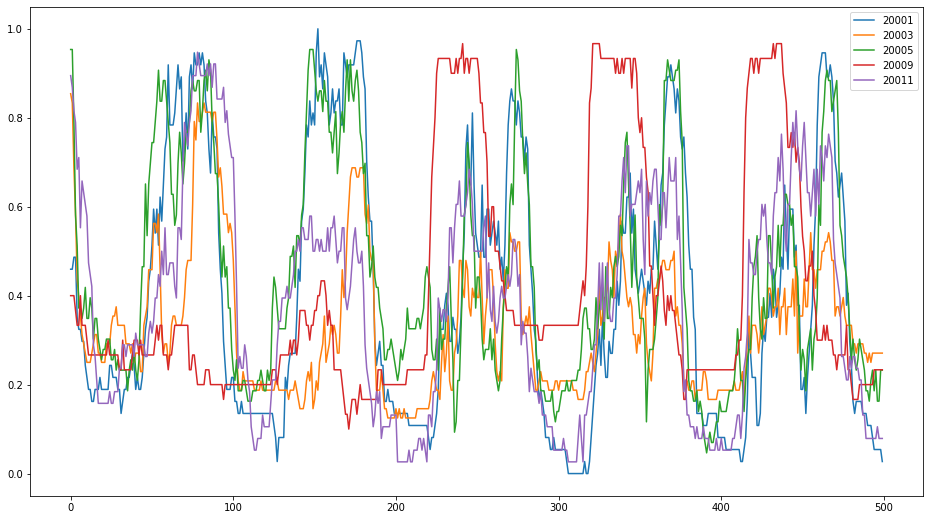

In [12]:
train_df.iloc[:500, 0:5].plot(figsize=(16, 9))
plt.show()

## Model

### Parameters

The parameters here are passed on to the Window Generator and the model.

`TIMESTEPS` indicates the time intervals that the data has been resampled too, in this case 15 mins. If the data input has been resampled to 5 mins, `TIMESTEPS = 5` etc.

`IN_STEPS` is the number of days used as an input for traning purposes. E.g. using 28 days input to predict an output, `IN_STEPS = int(28 * 24 * 60 / TIMESTEPS)`, if using 1 day input, `IN_STEPS = int(1 * 24 * 60 / TIMESTEPS)`.

`OUT_STEPS` is the number of days used as an output for traning purposes to test against. This is number of future days predicted by each training sample. E.g. using 1 day as output means given `IN_STEPS` days, predict the following 1 day's values in the given `TIMESTEPS` intervals.

More info on the `IN_STEPS` and `OUT_STEPS` functionalities can be read here: https://www.tensorflow.org/tutorials/structured_data/time_series#data_windowing

`LABEL_COLUMNS` is used to determine the output labels to predict e.g. if the input columns are the same as the output (`LABEL_COLUMNS = None`), the model will predict the results for all the input columns. When using exogenous variables e.g. weather data, we can continue to ONLY predict roadsegments by setting `LABEL_COLUMNS` = a list of roadsegment column names. In this way the model will take both the roadsegments and weather data as inputs and predict only for the `LABEL_COLUMNS` as outputs (the road segments).

More info on the `LABEL_COLUMNS` can be found here: https://www.tensorflow.org/tutorials/structured_data/time_series

`NUM_FEATURES` derives its value from the `LABEL_COLUMNS` and represents the number of input features used for the model prediction.

In [13]:
BATCH_SIZE = 512
MAX_EPOCHS = 23

# given 24 hours past (15 min intervals), predict 24h in the future
TIMESTEPS = 15 # data is in 15 min intervals
IN_STEPS = int(1 * 24 * 60 / TIMESTEPS)
OUT_STEPS = int(1 * 24 * 60 / TIMESTEPS)

LABEL_COLUMNS = list(data.columns[1:].values) # default = None

if LABEL_COLUMNS is not None:
    NUM_FEATURES = len(LABEL_COLUMNS)
else:
    NUM_FEATURES = df.shape[1]

LSTM_UNITS_1 = 128
LSTM_UNITS_2 = 128
DROPOUT_1 = 0.2
DROPOUT_2 = 0.2
LOSS = tf.losses.MeanSquaredError()
ACTIVATION = 'sigmoid'
OPTIMIZER = tf.optimizers.RMSprop()
METRICS = [tf.losses.MeanSquaredError(), tf.metrics.MeanAbsoluteError()]

### Data Windows

Data windows are important in time series prediction to maintain the sequentiality of data. Essentially, each batch is divided into subsamples of the time series data, such that an input 'window' is used to predict a subsequent output 'window'. Each training sample is split in this way.

More info on Data Windows in `TensorFlow` can be found here: https://www.tensorflow.org/tutorials/structured_data/time_series#data_windowing

For our model we use the architecture described here: https://www.tensorflow.org/tutorials/structured_data/time_series#single-shot_models

In [14]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                    train_df=train_df, val_df=val_df, test_df=test_df,
                    label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                                enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]


    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
    

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels


    def plot(self, model=None, plot_col=None, max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                    label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                            marker='X', edgecolors='k', label='Predictions',
                            c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time')


    def make_dataset(self, data, batch_size=BATCH_SIZE):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True, # Change this to False for final
            batch_size=batch_size,
            seed=SEED
            )

        ds = ds.map(self.split_window)

        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

Total window size: 192
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]
Label indices: [ 96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149
 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167
 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185
 186 187 188 189 190 191]
Label column name(s): ['20001', '20003', '20005', '20009', '20011', '20013', '20016', '20020', '20022', '20024', '20026', '20028', '20030', '20034', '20038', '20040', '20044', '20046', '20048', '20049', '20057', '20059', '20061', '20063', '20065', '20069', '20073

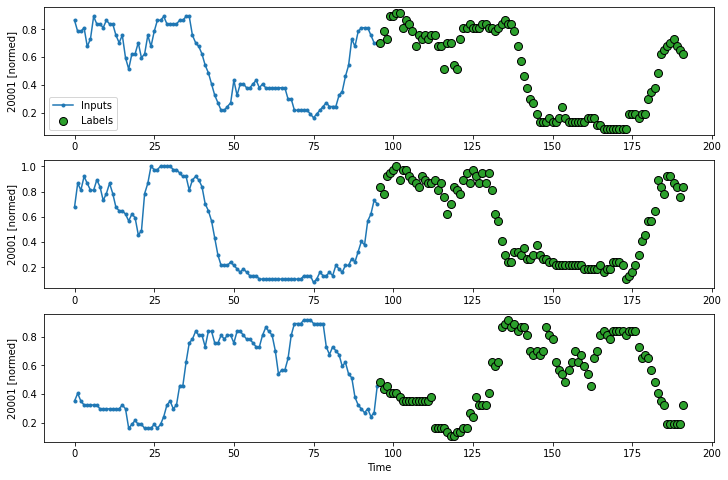

In [15]:
# create the data window
# the blue line represents the input window
# the green dots are the output window where predictions are tested against
multi_window = WindowGenerator(input_width=IN_STEPS,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               label_columns=LABEL_COLUMNS)

multi_window.plot(plot_col=LABEL_COLUMNS[0])
multi_window

### Training

For training, it is important to have the window large enough, such that one window can capture the an entire 'cycle' of seasonal behaviour. Naturally with respect to parking this could be 1 day, 1 week, 1 month, 1 season etc.


To retrain the model with a different dataset, first load the trained model using: 

```python
model = tf.keras.models.load_model('path_to_/my_model.h5', compile=False)
```

then call `model.fit()` on the new dataset. This has the benefit of initializing the model with its pretrained weight values which may be closer to the target, rather than starting from a blank initialization.

The new dataset must have the same number of columns as the previous trained model (predicting on the same road segments) otherwise the model must be retrained from scratch.



In [16]:
%%time

# multi_val_performance = {}
multi_performance = {}


model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    tf.keras.layers.LSTM(LSTM_UNITS_1, return_sequences=True),
    tf.keras.layers.Dropout(DROPOUT_1),

    tf.keras.layers.LSTM(LSTM_UNITS_2, return_sequences=False),
    tf.keras.layers.Dropout(DROPOUT_2),

    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*NUM_FEATURES,
                          activation=ACTIVATION,
                          kernel_initializer=tf.initializers.zeros()),
                    
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, NUM_FEATURES])
])


model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=METRICS)
    

history = model.fit(multi_window.train,
                    epochs=MAX_EPOCHS,
                    validation_data=multi_window.test
                    )

IPython.display.clear_output()

model.summary()


# multi_val_performance['LSTM'] = model.evaluate(multi_window.val, verbose=1)
multi_performance['LSTM'] = model.evaluate(multi_window.test, verbose=1)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 96, 128)           208896    
_________________________________________________________________
dropout (Dropout)            (None, 96, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 26784)             3455136   
_________________________________________________________________
reshape (Reshape)            (None, 96, 279)           0         
Total params: 3,795,616
Trainable params: 3,795,616
Non-trainable params: 0
______________________________________________

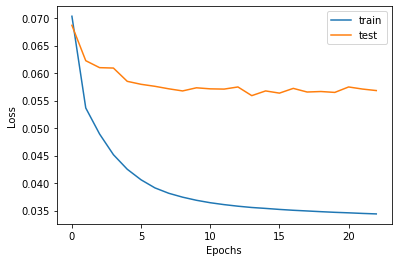

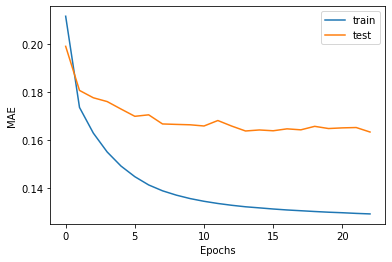

In [17]:
# Plot history: Loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="best")
plt.show()

# Plot history: MAE
plt.plot(history.history['mean_absolute_error'], label='train')
plt.plot(history.history['val_mean_absolute_error'], label='test')
plt.ylabel('MAE')
plt.xlabel('Epochs')
plt.legend(loc="best")
plt.show()

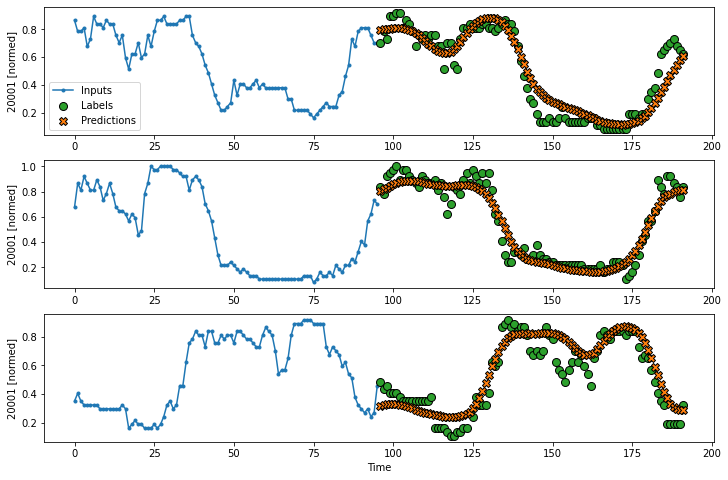

In [18]:
# plotting an example of the prediction
multi_window.plot(model, plot_col=LABEL_COLUMNS[0])

## Saving

We save the relevant files here and upload them to the `models/` folder in the GitHub repository. These files can be seen on the lefthand sidebar in Google Colab and downloaded from there.

In [19]:
model.save('my_model.h5')
pickle.dump(scaler, open('scaler.pkl', 'wb'))